#### Dependencies

In [1]:
from dataset_reader import Traces_Dataset
from DE_obj_model import de_obj_model   
from exp_hh_model import HH_model_exp
import numpy as np
import matplotlib.pyplot as plt

#### Read test dataset

In [2]:
dataset = Traces_Dataset('dataset_exp_test.csv')

sample = 5
params = dataset.params.numpy()
current_traces = dataset.current_traces.numpy()
time_traces = dataset.time_traces.numpy()

prestep_V_2d = dataset.prestep_V[sample].numpy().reshape(-1,1)
step_Vs_2d = (np.arange(dataset.step_V1[sample].numpy(), dataset.step_V1[sample].numpy() + dataset.num_traces*10, 10)).reshape(-1,1)
t = time_traces[sample]
# target_traces = current_traces[sample]
target_params = params[sample]

In [3]:
# sim setup for obj evaluation model
sim_setup_2d = {'prestep_V': prestep_V_2d, 'step_Vs': step_Vs_2d, 't': t}

# model = de_obj_model(target_params, sim_setup_2d)

In [4]:
# sim_traces = model.simulation()
# sim_traces.shape

#### Plotting function for trail, target, and real data

In [5]:
def plot_trail_target_real(sim_setup_1d, t, sim_traces, target_traces, target_params): 
    '''
    sim_setup_1d is the exp setup for hh model, all default as in hh class
    t is the target time traces from generated dataset
    sim_traces is the generated during searching stage
    target_traces is the target current traces from the generated dataset
    target_params is the target params from the generated dataset, dict
    '''
    # compare samples and simulations using sample params
    hh_model = HH_model_exp(target_params, sim_setup_1d)
    current_traces_sim = hh_model.simulation()

    colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta', 'brown', 'gray', 'black']

    for step in range(t.shape[0]): 
        plt.plot(t[step], sim_traces[step], linestyle='-', color=colors[step])
        plt.plot(t[step], target_traces[step], linestyle=':', color=colors[step])
        plt.plot(sim_setup_1d['t'], current_traces_sim[step], linestyle='--', color=colors[step])
    plt.legend()
    plt.title(f"prestep_V: {sim_setup_1d['prestep_V']}; step_V1: {sim_setup_1d['step_Vs'][0]}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


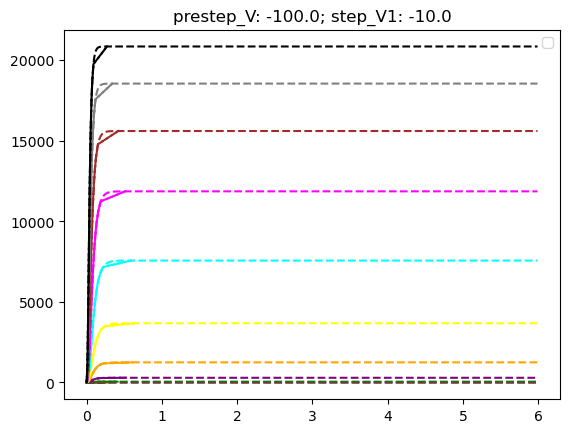

In [7]:
# sim setup for plotting real data
sim_setup_1d = {'prestep_V': np.squeeze(prestep_V_2d), 'step_Vs': np.squeeze(step_Vs_2d), 't': np.arange(0.0, 6.0, 0.01)}
target_params_dict = {'p': target_params[0], 'g_max': target_params[1], 'E_rev': target_params[2], 'a_m': target_params[3], 'b_m': target_params[4], 'delta_m': target_params[5], 's_m': target_params[6]}
plot_trail_target_real(sim_setup_1d, t, sim_traces, target_traces, target_params_dict)

#### Define obj function

In [5]:
def obj(x, *args): 
    '''
    x: a 1-D array of the variables for the obj function (the parameters we are estimating)
    args: a tupleo f additional fixed parameters (prestep_V, step_V0, time_traces)
    *args=(sim_setup_2d, target_params)
    '''
    trail_model = de_obj_model(x, args[0])
    trail_traces = trail_model.simulation()
    # print(trail_traces[1])
    target_model = de_obj_model(args[1], args[0])
    target_traces = target_model.simulation()
    # print(target_traces[1]) 
    
    return np.sum(np.square(trail_traces - target_traces))


In [6]:
fitness = obj(params[1], *(sim_setup_2d, target_params))
print(fitness)

13265556283.797617


#### Define bounds

In [7]:
# these bounds are from the distribution of the params in the dataset used for NN training
params_searching_bounds = {
    'p': (1, 5),
    'g_max': (100, 140), 
    'E_rev': (-100, -60), 
    'a_m': (0, 13), 
    'b_m': (0, 100), 
    'delta_m': (0, 1), 
    's_m': (-17, -10)
}
bounds = [params_searching_bounds['p'], params_searching_bounds['g_max'], params_searching_bounds['E_rev'], params_searching_bounds['a_m'], params_searching_bounds['b_m'], params_searching_bounds['delta_m'], params_searching_bounds['s_m']]

In [12]:
from scipy.optimize import differential_evolution
result = differential_evolution(obj, bounds, args=(sim_setup_2d, target_params), maxiter=10000)

/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exponential_Rates_varing_exp_setup/DE_obj_model.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  self.V_2m = - self.s_m * np.log(self.b_m / self.a_m)
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exponential_Rates_varing_exp_setup/DE_obj_model.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  tau_0m = (1 / self.a_m) * np.exp((self.delta_m * self.V_2m) / self.s_m)
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exponential_Rates_varing_exp_setup/DE_obj_model.py:41: RuntimeWarning: invalid value encountered in double_scalars
  tau_0m = (1 / self.a_m) * np.exp((self.delta_m * self.V_2m) / self.s_m)
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exponential_Rates_varing_exp_setup/DE_obj_model.py:42: RuntimeWarning: invalid value encountered in multiply
  return ((tau_0m * np.exp(self.delta_m * ((V - self.V_2m) / self.s_m))) / (1 + np.exp((V - self.V_2m) / 

In [13]:
target_params, result.x

(array([  5.        , 116.29313   , -63.79731   ,   1.0007432 ,
         38.80055   ,   0.28924733, -11.049835  ], dtype=float32),
 array([  5.        , 116.29312897, -63.79730988,   1.00074316,
         38.80055161,   0.28924733, -11.04983521]))

In [14]:
((target_params - result.x) ** 2)

array([0.00000000e+00, 0.00000000e+00, 2.01948392e-28, 7.09610104e-17,
       9.32081165e-12, 0.00000000e+00, 1.26217745e-29])

In [15]:
result.x

array([  5.        , 116.29312897, -63.79730988,   1.00074316,
        38.80055161,   0.28924733, -11.04983521])

In [19]:
result

 message: Optimization terminated successfully.
 success: True
     fun: 1.2912231551188393e-22
       x: [ 5.000e+00  1.163e+02 -6.380e+01  1.001e+00  3.880e+01
            2.892e-01 -1.105e+01]
     nit: 1953
    nfev: 205186

#### Run DE on all test dataset, check result mse on all params here

In [16]:
mse_mat = np.load('de_mse_params_all_test.npy')

In [17]:
mse_mat.shape

(30, 7)

In [18]:
mse_params = np.mean(mse_mat, axis=0)
mse_params

array([1.68353114e-03, 5.70682053e+01, 1.12901201e+02, 2.79381230e-03,
       7.58826951e+00, 1.83145674e-04, 7.30552287e-02])

## Define obj fct and estimate for single param

In [20]:
def obj_i_param(x, *args): 
    '''
    x: a single float value of the i-th param
    args: a tupleo f additional fixed parameters (prestep_V, step_V0, time_traces)
    *args=(i, sim_setup_2d, target_params)
    '''
    params = args[2].copy()
    params[args[0]] = x
    trail_model = de_obj_model(params, args[1])
    trail_traces = trail_model.simulation()
    # print(trail_traces[1])
    target_model = de_obj_model(args[2], args[1])
    target_traces = target_model.simulation()
    # print(target_traces[1]) 
    
    return np.sum(np.square(trail_traces - target_traces))

In [21]:
params_searching_bounds = {
    'p': (1, 5),
    'g_max': (100, 140), 
    'E_rev': (-100, -60), 
    'a_m': (0, 13), 
    'b_m': (0, 100), 
    'delta_m': (0, 1), 
    's_m': (-17, -10)
}
i = 6
key_at_index = list(params_searching_bounds.keys())[i]
bounds = [params_searching_bounds[key_at_index]]
bounds

[(-17, -10)]

In [22]:
from scipy.optimize import differential_evolution
result = differential_evolution(obj_i_param, bounds, args=(i, sim_setup_2d, target_params), maxiter=100)#, tol = 1e-10)
result

 message: Optimization terminated successfully.
 success: True
     fun: 0.0
       x: [-1.105e+01]
     nit: 22
    nfev: 347

In [32]:
((target_params[i] - result.x) ** 2)

array([2.0789837e-15])

#### Results for all single param estimation

In [27]:
mses = np.load('de_mses_on_ith_params.npy')
nits = np.load('de_nit_on_ith_params.npy')
mses.shape, nits.shape

((30, 7), (30, 7))

In [28]:
arr = mses.mean(axis=0)
print(arr)

sorted_indices = np.argsort(arr)

print("Sorted indices:", sorted_indices)

[1.40752475e-15 6.77700377e-15 2.20245039e-15 1.40308669e-15
 2.14625476e-15 1.44141350e-15 2.20503233e-15]
Sorted indices: [3 0 5 4 2 6 1]


In [29]:
arr = nits.mean(axis=0)
print(arr)

sorted_indices = np.argsort(arr)

print("Sorted indices:", sorted_indices)

[27.         26.1        26.53333333 26.53333333 26.83333333 27.23333333
 26.33333333]
Sorted indices: [1 6 2 3 4 0 5]
